In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import wrangle
import explore
import model

import warnings
warnings.filterwarnings("ignore")

# Notebook for documenting Zillow project data preparation and exploration work:
- Goal is to predict home value (tax_value)
- Initially just using number of bedrooms, bathrooms, and square footage to predict
- Drop outliers and nulls

## Once MVP complete, additional items to test:
- Imputing nulls (mean, median, or maybe based on bedroom and bathroom number) 
- Additional features from database
- Outlier handling:
    - Using RobustScaler or QuatileScaler to include outliers
    - Removing outliers by train, validate, test sets and not just the whole dataset
    - Including outliers
- Additional features to add and engineer
- Feature selection


In [2]:
df = wrangle.wrangle_zillow()

Using cached data


In [3]:
df.shape

(52442, 20)

In [4]:
df.isna().sum()

bedroom           0
bathroom          0
square_feet      82
tax_value         1
fips              0
garage            0
yearbuilt       116
condition         0
zip              26
pool              0
lot_size        369
age             116
living_space     82
room_count        0
county            0
is_LA             0
bedroom_cat       0
bathroom_cat      0
has_garage        0
bed_to_bath       0
dtype: int64

In [5]:
# Make column for home age
# df["age"] = 2017 - df.yearbuilt

In [6]:
# Make a column for living space. Average bathroom is 40 sq ft, average bedroom is 200 sq ft
# df["living_space"] = df.bathroom*40 + df.bedroom*200

In [7]:
# Convert bedrooms to integer type
# df.bedroom = df.bedroom.astype('int')

# Univariate exploration

### Box Plots

In [8]:
features_to_plot = ['bedroom', 'bathroom', 'square_feet', 'tax_value', 'living_space','age']

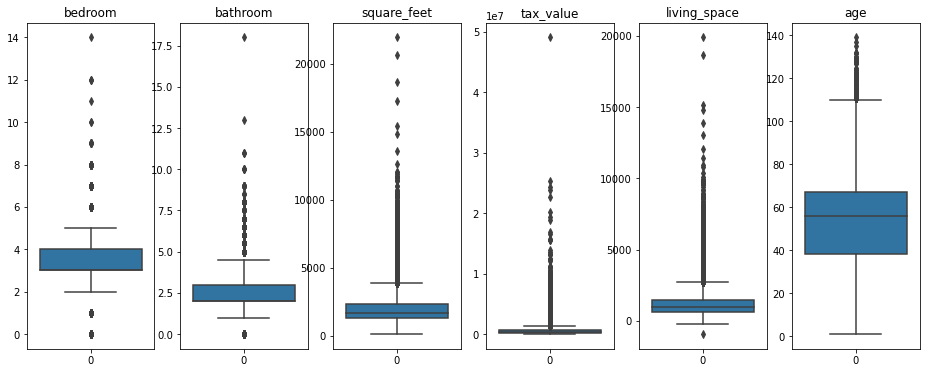

In [9]:
explore.plot_boxplots(df, features_to_plot)

## Takeaways:
- Some outliers for bedroom and bathroom but for the most part clustered between 2-4
- Lots of square footage outliers
- Very high outliers for tax value makes it difficult to visualize the lower end of home values, where most observations look to be

### Histograms

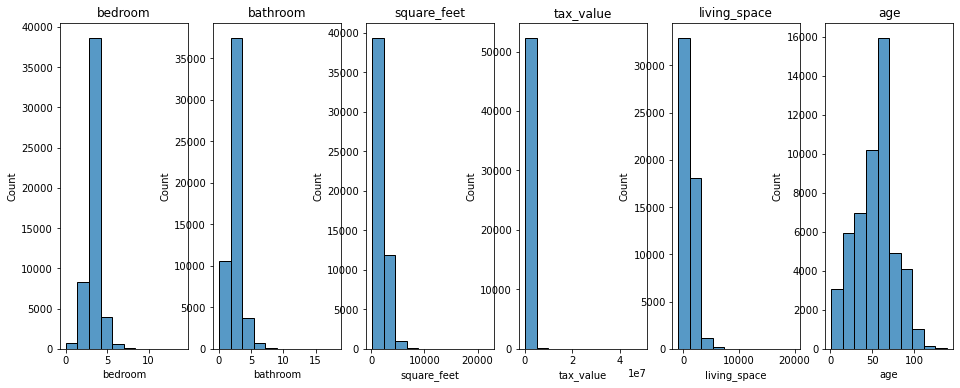

In [10]:
explore.plot_histograms(df, features_to_plot)

## Takeaways:
- Fairly normal distribution for bedroom and bathroom
- Square footage and tax_value look very skewed to the left due to some very high outliers

### Will drop outliers going forward for this MVP

In [11]:
df.columns

Index(['bedroom', 'bathroom', 'square_feet', 'tax_value', 'fips', 'garage',
       'yearbuilt', 'condition', 'zip', 'pool', 'lot_size', 'age',
       'living_space', 'room_count', 'county', 'is_LA', 'bedroom_cat',
       'bathroom_cat', 'has_garage', 'bed_to_bath'],
      dtype='object')

In [12]:
# using a setting of 3 to keep as much data as possible
# df_outlier_removed = wrangle.remove_outliers(df, 3, ['bathroom','bedroom','square_feet', 'tax_value','age'])
df_outlier_removed = wrangle.remove_outliers_std(df, 2.0, ['tax_value','lot_size','bedroom','bathroom','living_space'])

Number of observations removed: 4652


In [13]:
df_outlier_removed.shape

(47790, 20)

In [14]:
# df_outlier_removed = df_outlier_removed.dropna()

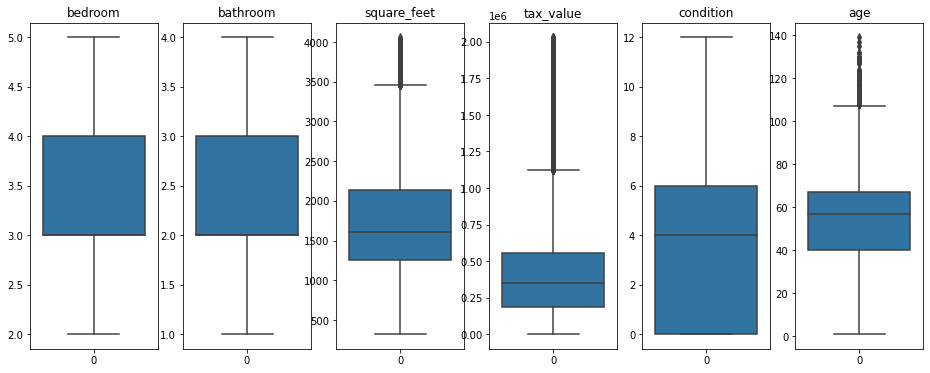

In [15]:
explore.plot_boxplots(df_outlier_removed, ['bedroom', 'bathroom', 'square_feet', 'tax_value','condition','age'])

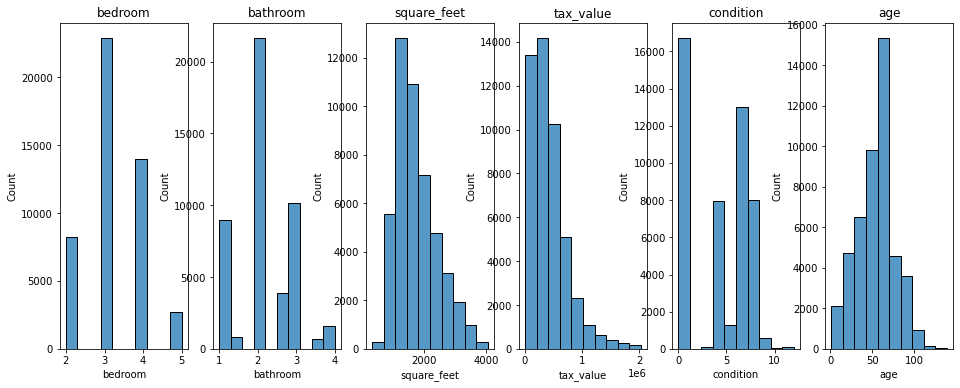

In [16]:
explore.plot_histograms(df_outlier_removed, ['bedroom', 'bathroom', 'square_feet', 'tax_value','condition','age'])

### With outliers removed:
- Relatively normal distributions for bedrooms, bathrooms, and square feet
- Left skewed for tax_value

### Condition data

In [17]:
# # Condition data only available for fips 6037.0. Will be dropping nans going forward but do not want to drop every row from other fips.
# df_outlier_removed.condition = df_outlier_removed.condition.fillna(0)

### Garage data

In [18]:
# df_outlier_removed[df_outlier_removed.fips == 6111.0].garage.value_counts(dropna=False)

### no garage data for fips 06037

In [19]:
df.shape

(52442, 21)

In [20]:
# For MVP will just drop rows with NA. For the df with outliers removed this represents 55 rows of 50669 or <0.2%
df = df_outlier_removed.dropna()


In [21]:
df.shape

(47509, 20)

### Property locations

In [22]:
# def get_locations_from_fips(fip):
#     if int(fip) == 6037:
#         return "Los Angeles County"
#     if int(fip) == 6059:
#         return "Orange County"
#     if int(fip) == 6111:
#         return "Ventura County"

In [23]:

# df["county"] = np.select([df.fips == 6037, df.fips==6059, df.fips == 6111],["Los Angeles County", "Orange County", "Ventura County"])

In [24]:
# df["county"] = df.fips.apply(lambda x: get_locations_from_fips(x))

In [25]:
df.county.value_counts()

Los Angeles County    30896
Orange County         12633
Ventura County         3980
Name: county, dtype: int64

## Splitting data going forward to explore multivariate relationships

In [26]:
train, validate, test = wrangle.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [27]:
train.shape

(26604, 20)

In [28]:
train.columns

Index(['bedroom', 'bathroom', 'square_feet', 'tax_value', 'fips', 'garage',
       'yearbuilt', 'condition', 'zip', 'pool', 'lot_size', 'age',
       'living_space', 'room_count', 'county', 'is_LA', 'bedroom_cat',
       'bathroom_cat', 'has_garage', 'bed_to_bath'],
      dtype='object')

#### Adding columns to simplify bedroom and bathroom counts as categoricals:
- Bedrooms: 3, more than 3, 2 or less
- Bathrooms: 2, more than 2, less than 2

#### Adding column to categorize whether a house has a garage or not

In [29]:
# def bedroom_mapper(num):
#     """ Map the number of bedrooms to a categorical label """
#     if num <= 2:
#         return "2_or_less"
#     elif num <=3:
#         return "3"
#     elif num > 3:
#         return "more_than_3"

In [30]:
# def bathroom_mapper(num):
#     """ Map the number of bathrooms to a categorical label """
#     if num == 2:
#         return "2"
#     elif num < 2:
#         return "less_than_2"
#     elif num > 2:
#         return "more_than_2"

In [31]:
# # Applying this feature to all data sets
# train["bedroom_cat"] = train.bedroom.apply(lambda row: bedroom_mapper(row))
# validate["bedroom_cat"] = validate.bedroom.apply(lambda row: bedroom_mapper(row))
# test["bedroom_cat"] = test.bedroom.apply(lambda row: bedroom_mapper(row))

In [32]:
# train["bathroom_cat"] = train.bathroom.apply(lambda row: bathroom_mapper(row))
# validate["bathroom_cat"] = validate.bathroom.apply(lambda row: bathroom_mapper(row))
# test["bathroom_cat"] = test.bathroom.apply(lambda row: bathroom_mapper(row))

In [33]:
# train["has_garage"] = np.where(train.garage>0, True, False)
# validate["has_garage"] = np.where(validate.garage>0, True, False)
# test["has_garage"] = np.where(test.garage>0, True, False)

In [34]:
train.shape

(26604, 20)

Generating plots tax_value by bedroom_cat


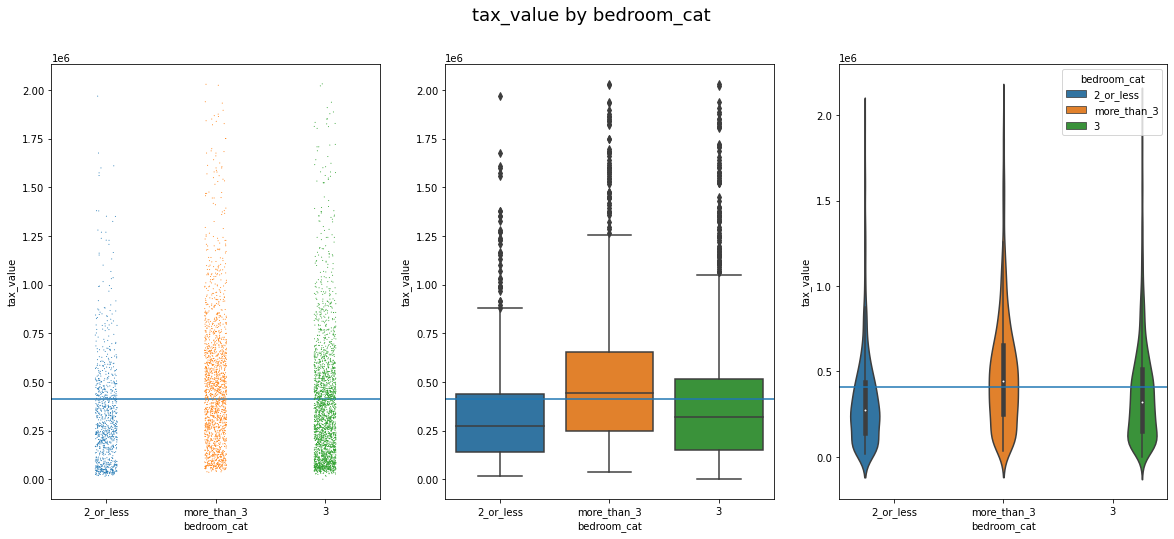

Generating plots tax_value by bathroom_cat


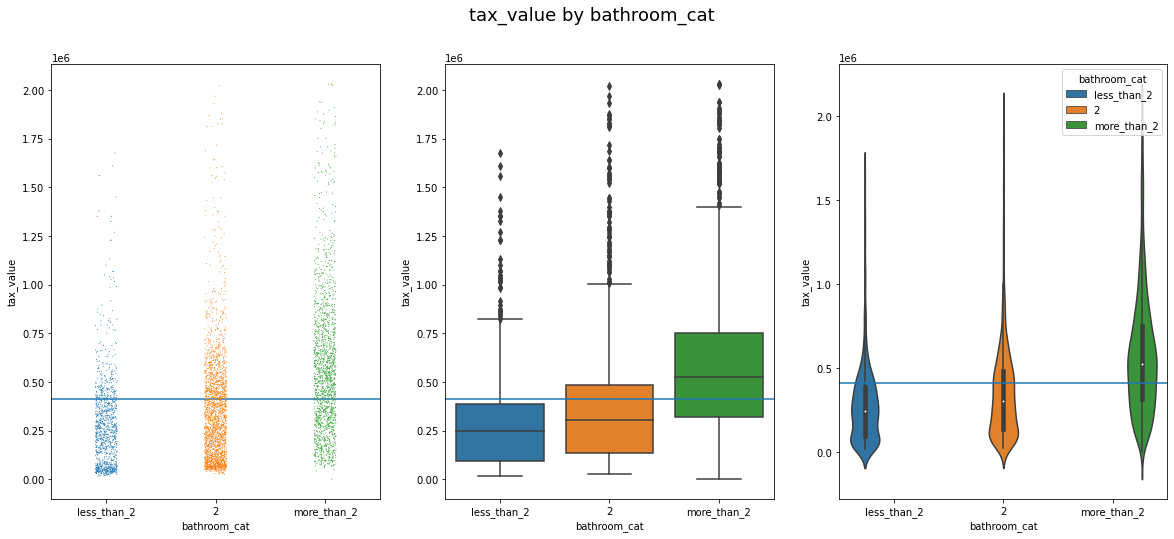

Generating plots tax_value by county


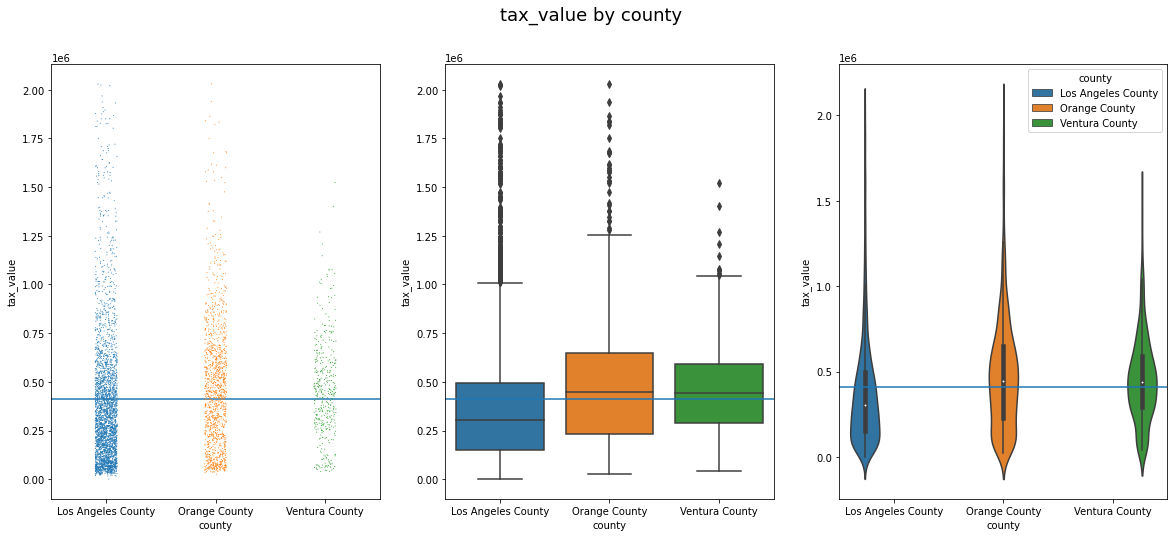

Generating plots tax_value by pool


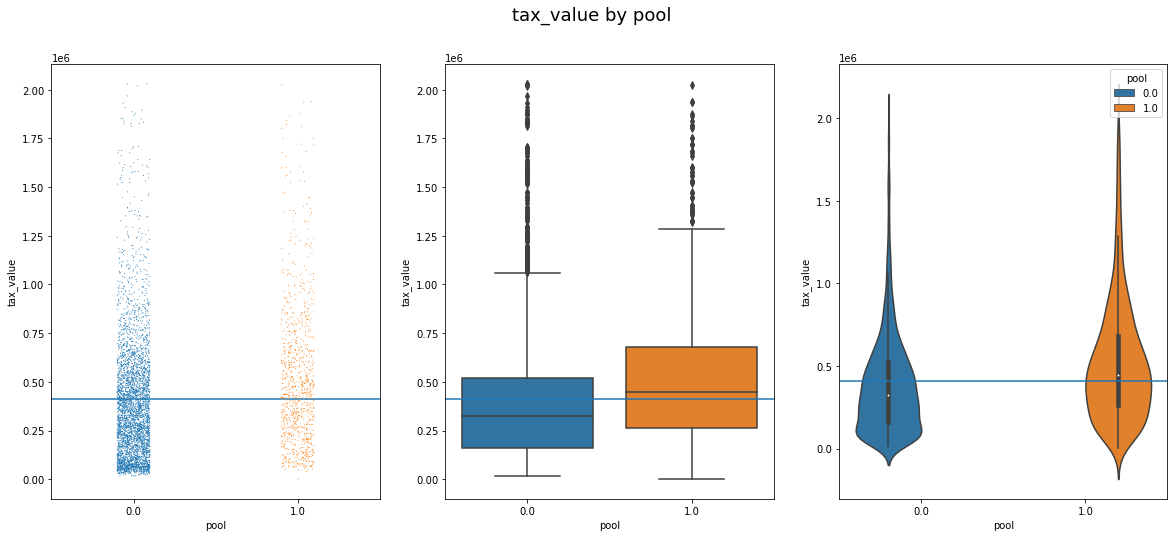

In [35]:
# for county in train.county:
#     print(county)
    # explore.plot_categorical_and_continuous_vars(train[train.county == county], ['bedroom_cat','bathroom_cat','condition'], ['tax_value'], sample_amt = 5000)
explore.plot_categorical_and_continuous_vars(train, ['bedroom_cat','bathroom_cat','county','pool'], ['tax_value'], sample_amt = 5000)

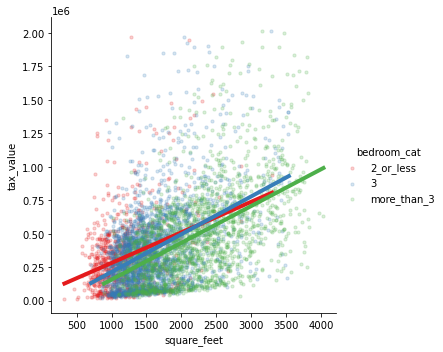

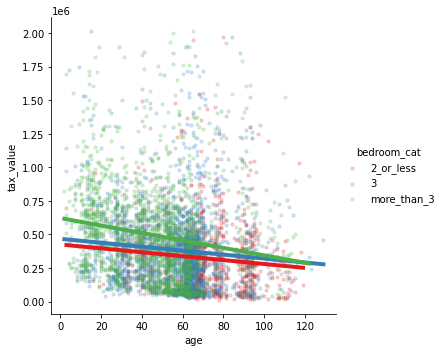

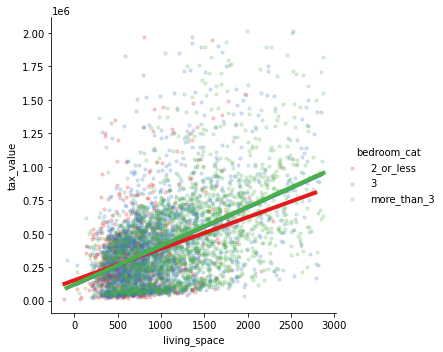

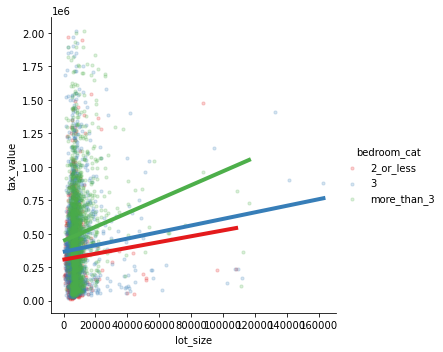

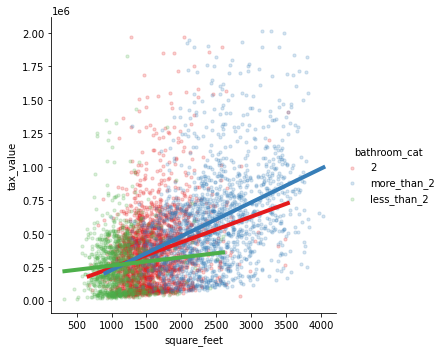

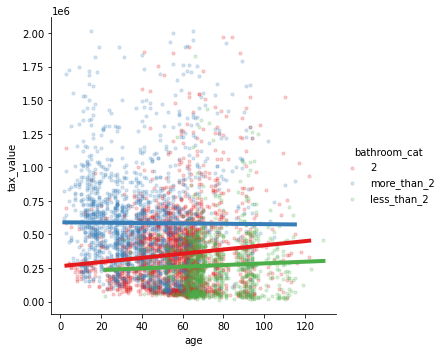

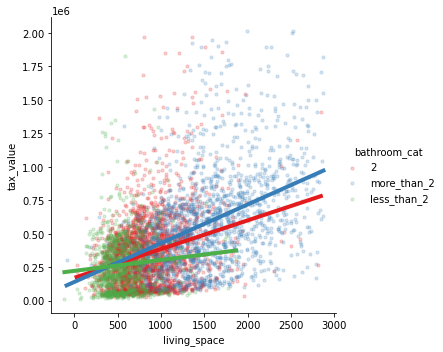

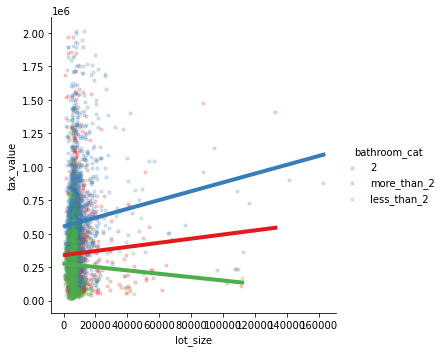

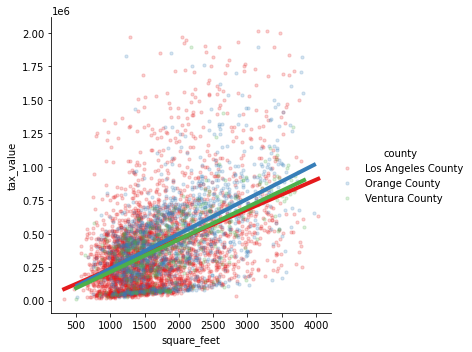

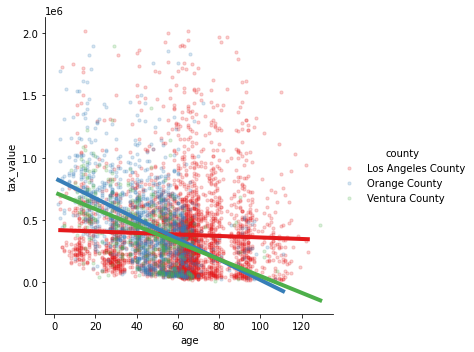

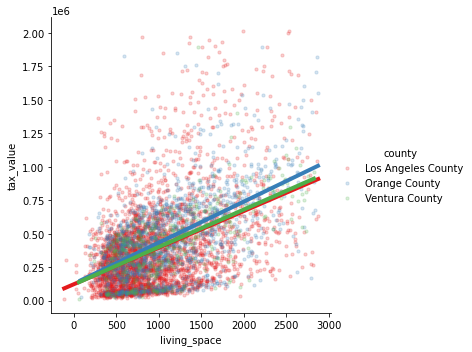

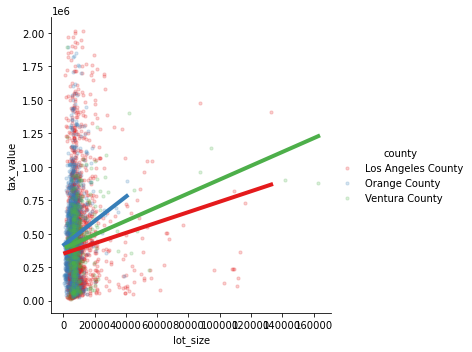

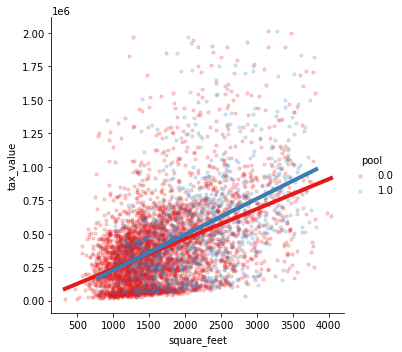

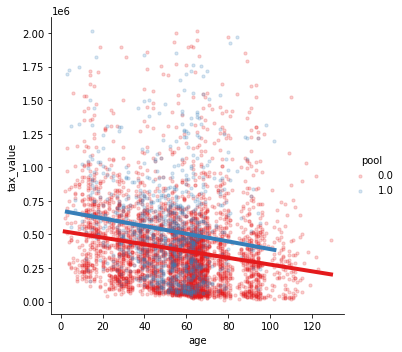

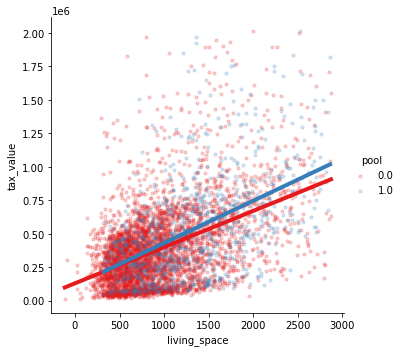

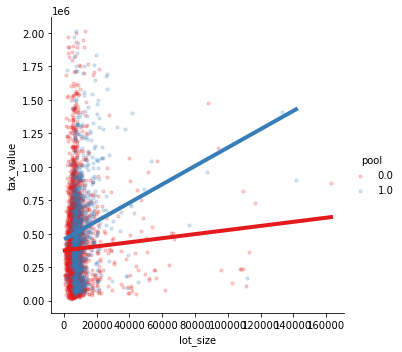

In [36]:
explore.plot_variable_pairs(train, ['square_feet','age','living_space','lot_size'], categoricals = ['bedroom_cat','bathroom_cat','county','pool'], targets=['tax_value'], sample_amt=5000)

Text(0.5, 1.0, 'Mean home value by county')

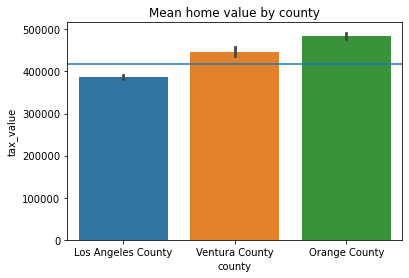

In [37]:
sns.barplot(data = train, x = train.county, y = train.tax_value,  estimator=np.mean)
plt.axhline(train.tax_value.mean())
plt.title("Mean home value by county")

### Takeaways:
- Average tax value looks to be higher than the overall average for more than 3 bedrooms and lower for 3 or less:
    - check with 1 sample t test for all 3 categories
- Average tax value looks to be higher than the overall average for more than 2 bathrooms and lower for 2 or less
    - check with 1 sample t test for all 3 categories
- Seems to be a linear relationship between square feet and tax value
    - check with a correlation test (Pearson)
- Having a garage seems to add value to a home
    - check a 2 sample t test for two categories and a 1 sample test vs overall mean
- The greater the age the lower the value in general
    - check with a correlation test
- The county home is in affects the tax value: LA looks to be less than other two
    - will confirm with 1 sample t test for all 3 counties
- Having a pool seems more valuable than not
    - will confirm with 1 sample t test for both categories
- Bedroom count does not have a great effect on the square feet to tax value relationship
- Bathroom count also does not have a great effect on the square feet to tax value relationship but there is a little more variation in the slope of the lines 

### Statistical tests of tax values depending on bedroom and bathroom count category
- all 1 sample t test to check the category average tax value vs the overall
- will check if significantly higher or lower depending on 2-tailed test result
- assumptions for t-test will be checked prior to performing test -> all categories have >> 30 samples
- $H_0$ for all is that the category average is not significantly different from the overall average
- alpha value is 0.05 for all

In [38]:
alpha = 0.05

### Start with bedroom category

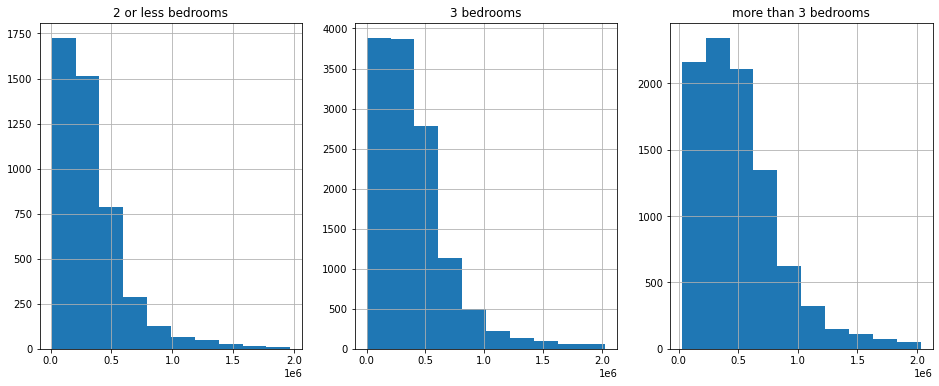

In [39]:
plt.figure(figsize=(16,6))
for i, bed_cat in enumerate(set(train.bedroom_cat)):
    plt.subplot(1, 3, i+1)
    plt.title(bed_cat.replace("_"," ")+" bedrooms")
    train.tax_value[train.bedroom_cat == bed_cat].hist()

### Approximately normal distribution but very much skewed to the left

In [40]:
for bed_cat in set(train.bedroom_cat):
    sample = train.tax_value[train.bedroom_cat == bed_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(bed_cat, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for bed_cat in set(train.bedroom_cat):
    sample = train.tax_value[train.bedroom_cat == bed_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='greater')
    if p/2 < alpha:
        print(bed_cat, round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='less')
    
    if p/2 < alpha:
        print(bed_cat, round(t,2), "Significantly Less")

2_or_less -21.01 Significant (2-tail)? True
3 -9.94 Significant (2-tail)? True
more_than_3 22.29 Significant (2-tail)? True
-----------
2_or_less -21.01 Significantly Less
3 -9.94 Significantly Less
more_than_3 22.29 Significantly Greater


### Based on t-test, 3 or fewer bedrooms tax values are significantly less than the average, while more than 3 is signficantly more

In [41]:
# Maybe t test is not applicable given not so normal distributed?
# for bed_cat in set(train.bedroom_cat):
#     sample = train.tax_value[train.bedroom_cat == bed_cat]
#     u, p = stats.wilcoxon(sample, train.tax_value.mean())
#     print(bed_cat, round(u,2), "Significant (2-tail)?", p < alpha)
# print("-----------")
# for bed_cat in set(train.bedroom_cat):
#     sample = train.tax_value[train.bedroom_cat == bed_cat]
#     u, p = stats.wilcoxon(sample, train.tax_value.mean(),alternative='greater')
#     if p/2 < alpha:
#         print(bed_cat, round(u,2), "Significantly Greater")
        
#     u, p = stats.wilcoxon(sample, train.tax_value.mean(),alternative='less')
    
#     if p/2 < alpha:
#         print(bed_cat, round(u,2), "Significantly Less")

### Moving on to bathrooms

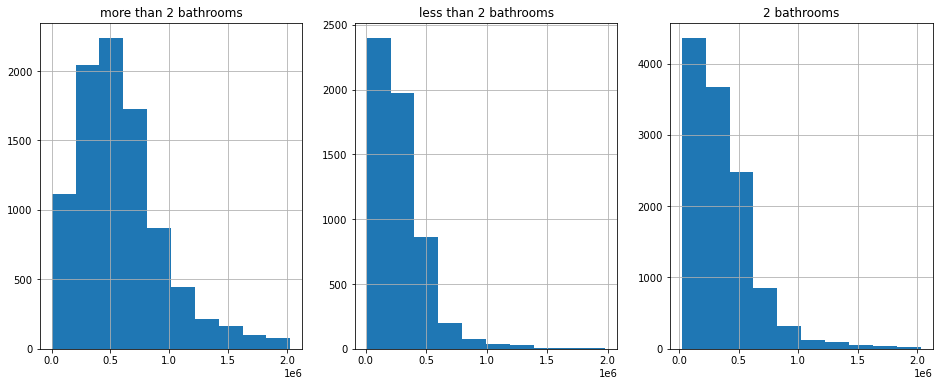

In [42]:
plt.figure(figsize=(16,6))
for i, bath_cat in enumerate(set(train.bathroom_cat)):
    plt.subplot(1, 3, i+1)
    plt.title(bath_cat.replace("_"," ")+" bathrooms")
    train.tax_value[train.bathroom_cat == bath_cat].hist()

### Approximately normal distribution but very much skewed to the left

In [43]:
for bath_cat in set(train.bathroom_cat):
    sample = train.tax_value[train.bathroom_cat == bath_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(bath_cat, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for bath_cat in set(train.bathroom_cat):
    sample = train.tax_value[train.bathroom_cat == bath_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    if p/2 < alpha and t>0:
        print(bath_cat, round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    
    if p/2 < alpha and t<0:
        print(bath_cat, round(t,2), "Significantly Less")

more_than_2 43.86 Significant (2-tail)? True
less_than_2 -46.81 Significant (2-tail)? True
2 -24.04 Significant (2-tail)? True
-----------
more_than_2 43.86 Significantly Greater
less_than_2 -46.81 Significantly Less
2 -24.04 Significantly Less


## Based on t-test, 2 or fewer bathrooms have tax values significantly lower than the overall average while greater than 2 bathrooms results in higher than average values

### Check whether having garage or not better for home value

In [44]:
with_garage_sample = train[train.has_garage==1]
without_garage_sample = train[train.has_garage==0]

# check variances
statistic, p = stats.levene(with_garage_sample.tax_value, without_garage_sample.tax_value)

In [45]:
without_garage_sample.tax_value

51939     646000.0
5227      107863.0
19889    1142211.0
22308      31215.0
10356     536601.0
           ...    
12930     723837.0
30580      46545.0
46496      66059.0
50904     535751.0
9752      520400.0
Name: tax_value, Length: 17506, dtype: float64

In [46]:
if p<0.05:
    print("Reject null hypothesis - can assume variances are unequal")

In [47]:
t, p = stats.ttest_ind(with_garage_sample.tax_value, without_garage_sample.tax_value,equal_var=False)

In [48]:
t,p

(22.858665762535466, 3.720169852408407e-114)

In [49]:
t, p = stats.ttest_1samp(with_garage_sample.tax_value, train.tax_value.mean())

In [50]:
t,p

(19.017467001062613, 4.1365593367171116e-79)

### Having a garage definitely better than not having one

## Checking counties

In [51]:
# Perform 1 sample t-test comparing each county's average tax value to the overall average
for county in set(train.county):
    sample = train.tax_value[train.county == county]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(county, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for county in set(train.county):
    sample = train.tax_value[train.county == county]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    if (p/2 < alpha) and (t>0):
        print(county, " t: ", round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    
    if (p/2 < alpha) and (t<0):
        print(county, round(t,2), "Significantly Less")

Orange County 17.69 Significant (2-tail)? True
Ventura County 5.23 Significant (2-tail)? True
Los Angeles County -12.46 Significant (2-tail)? True
-----------
Orange County  t:  17.69 Significantly Greater
Ventura County  t:  5.23 Significantly Greater
Los Angeles County -12.46 Significantly Less


### Confirm that Orange and Ventura counties have tax values above the overall mean, while LA has lower

### Pools

In [52]:
for pool in set(train.pool):
    sample = train.tax_value[train.pool == pool]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(pool, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for pool in set(train.pool):
    sample = train.tax_value[train.pool == pool]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='greater')
    if p/2 < alpha:
        print(pool, " t: ", round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='less')
    
    if p/2 < alpha:
        print(pool, round(t,2), "Significantly Less")

0.0 -14.0 Significant (2-tail)? True
1.0 23.87 Significant (2-tail)? True
-----------
0.0 -14.0 Significantly Less
1.0  t:  23.87 Significantly Greater


### Confirm having a pool tax value higher than not

### Analyzing correlation between variables

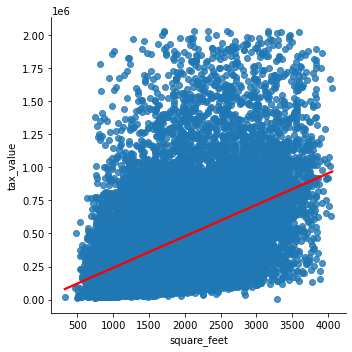

In [53]:
sns.lmplot(data = train, x= 'square_feet', y='tax_value', line_kws={'color':'red'})

### Looks like a fairly linear relationship between square footage and tax value

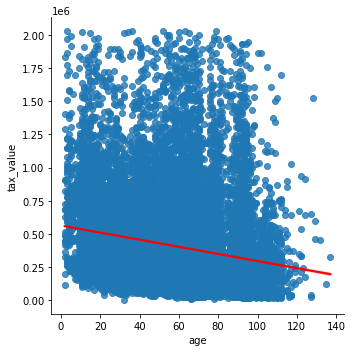

In [54]:
sns.lmplot(data = train, x= 'age', y='tax_value', line_kws={'color':'red'})

### Looks like as age increases tax value decreases

### Does the ratio of bedrooms to bathrooms have any effect on tax value?

In [55]:
# # Do have some 0 values for num of bathrooms, so replace these with 0
# train["bed_to_bath"] = (train.bedroom/train.bathroom).replace(np.inf, 0).fillna(0)
# validate["bed_to_bath"] = (validate.bedroom/validate.bathroom).replace(np.inf, 0).fillna(0)
# test["bed_to_bath"] = (test.bedroom/test.bathroom).replace(np.inf, 0).fillna(0)

In [56]:
r, p = stats.pearsonr(train.bed_to_bath, train.tax_value)
print("p<alpha: ", p<alpha, ",correlation: ", r, "weak negative")

p<alpha:  True ,correlation:  -0.26881409841011583 weak negative


## Check correlation of all variables to target

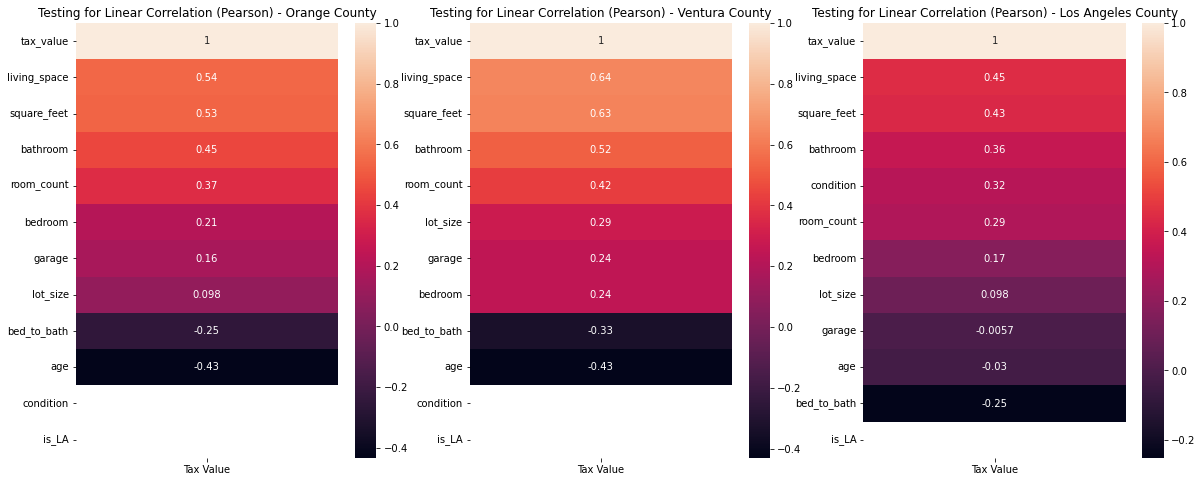

In [57]:
plt.figure(figsize=(20,8))
for i, county in enumerate(set(train.county)):
    sample = train[train.county == county].drop(columns = ['yearbuilt','pool','has_garage','zip','fips'])
    linear_correlation = pd.DataFrame({"Tax Value":sample.corrwith(sample.tax_value,method='pearson')}).sort_values(by='Tax Value',ascending=False)

    # non_linear_correlation = pd.DataFrame({"Tax Value":sample.corrwith(sample.tax_value,method='spearman')}).sort_values(by='Tax Value',ascending=False)

    plt.subplot(1, 3, i+1)
    plt.title(f"Testing for Linear Correlation (Pearson) - {county}")
    sns.heatmap(linear_correlation, annot=True)

In [58]:
# plt.figure(figsize=(12,6))
# plt.title("Testing for Non-Linear Correlation (Spearman)")
# sns.heatmap(non_linear_correlation, annot=True)

### Takeaways:
- Relatively high correlation with square footage and bathroom count:
    - As these two values increase, home value does as well
- LA county is the only county with condition information and this shows a moderate correlation with tax value
- Weak correlation between garage count, bedroom count and tax value
- No variable here has very high correlation - other factors must influence

# Try a different scaling approach

# Modeling

### Prepare datasets per curriculum

In [59]:
train.columns

Index(['bedroom', 'bathroom', 'square_feet', 'tax_value', 'fips', 'garage',
       'yearbuilt', 'condition', 'zip', 'pool', 'lot_size', 'age',
       'living_space', 'room_count', 'county', 'is_LA', 'bedroom_cat',
       'bathroom_cat', 'has_garage', 'bed_to_bath'],
      dtype='object')

In [60]:
# These are the features that need to be encoded
to_dummy = ['bedroom_cat','bathroom_cat','county']
# These are the features that need to be scaled
# features_to_scale = ['bathroom','bedroom','square_feet','age','bed_to_bath','living_space','condition','lot_size','room_count']
features_to_scale = ['age','living_space','square_feet','bathroom','bedroom']
# These are the features that will be fed into the model based on exploration
# columns_to_use = ['avg_room_space','bathroom','bedroom','condition','lot_size','square_feet','age','living_space','pool','bed_to_bath','has_garage','room_count']
columns_to_use = ['age','living_space','pool','has_garage','square_feet','bathroom','bedroom']

In [61]:
# Test each county with each regression algorithm
all_results = {}
for county in set(train.county):
    print(county)
    
    train_sample = train[train.county == county]
    validate_sample = validate[validate.county == county]
    test_sample = test[test.county == county]

    X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features = model.model_feature_selection(train_sample, validate_sample, test_sample, to_dummy, features_to_scale, columns_to_use)
    
    print(rfe_features)
    all_results[county]=model.model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features)

Orange County
['has_garage', 'age_scaled', 'living_space_scaled']
RMSE using Mean
Train/In-Sample:  317884.84 
Validate/Out-of-Sample:  324148.76
RMSE using Median
Train/In-Sample:  320434.13 
Validate/Out-of-Sample:  326912.69
RMSE for OLS using LinearRegression
Training/In-Sample:  260610.98133650582 
Validation/Out-of-Sample:  270284.3662718425
RMSE for OLS using LarsLasso
Training/In-Sample:  260611.03441137998 
Validation/Out-of-Sample:  270287.82635109045
RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  255646.7672003792 
Validation/Out-of-Sample:  266385.47513883974
RMSE for Polynomial Model, degrees=2
Training/In-Sample:  264397.0605204695 
Validation/Out-of-Sample:  277226.0789262193
Ventura County
['living_space_scaled', 'square_feet_scaled', 'bedroom_scaled']
RMSE using Mean
Train/In-Sample:  259436.23 
Validate/Out-of-Sample:  252917.11
RMSE using Median
Train/In-Sample:  260589.67 
Validate/Out-of-Sample:  253302.31
RMSE for OLS using LinearRegression
Tra

In [62]:
# These are the features that need to be encoded
to_dummy = ['bedroom_cat','bathroom_cat','county']
# These are the features that need to be scaled
# features_to_scale = ['bathroom','bedroom','square_feet','age','bed_to_bath','living_space','condition','lot_size','room_count']
features_to_scale = ['age','living_space','condition','square_feet','bathroom']
# These are the features that will be fed into the model based on exploration
columns_to_use = ['bedroom', 'bathroom', 'square_feet',
       'condition', 'pool', 'lot_size', 'age',
       'living_space', 'room_count', 'has_garage', 'bed_to_bath',
       'bedroom_cat_3', 'bedroom_cat_more_than_3', 'bathroom_cat_less_than_2',
       'bathroom_cat_more_than_2', 'county_Orange County',
       'county_Ventura County','is_LA']

In [63]:
# Test all counties together    
train_sample = train
validate_sample = validate
test_sample = test

X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features = model.model_feature_selection(train_sample, validate_sample, test_sample, to_dummy, features_to_scale, columns_to_use)

print(rfe_features)
# all_results.append(model.model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features))

['county_Orange County', 'county_Ventura County', 'is_LA']


In [64]:
X_train_exp = pd.get_dummies(train, columns = to_dummy, drop_first=True)

In [65]:
X_train_exp.columns

Index(['bedroom', 'bathroom', 'square_feet', 'tax_value', 'fips', 'garage',
       'yearbuilt', 'condition', 'zip', 'pool', 'lot_size', 'age',
       'living_space', 'room_count', 'is_LA', 'has_garage', 'bed_to_bath',
       'bedroom_cat_3', 'bedroom_cat_more_than_3', 'bathroom_cat_less_than_2',
       'bathroom_cat_more_than_2', 'county_Orange County',
       'county_Ventura County'],
      dtype='object')

In [66]:
# These are the features that will be fed into the model based on exploration
columns_to_use = ['bedroom', 'bathroom', 'square_feet',
       'condition', 'pool', 'lot_size', 'age',
       'living_space', 'room_count', 'has_garage', 'bed_to_bath',
       'bedroom_cat_3', 'bedroom_cat_more_than_3', 'bathroom_cat_less_than_2',
       'bathroom_cat_more_than_2', 'is_LA']
# 'county_Orange County',
       # 'county_Ventura County',

In [67]:
X_train = X_train_exp[columns_to_use]
X_validate = pd.get_dummies(validate, columns = to_dummy, drop_first=True)[columns_to_use]
X_test = pd.get_dummies(test, columns = to_dummy, drop_first=True)[columns_to_use]

In [68]:
X_train.columns

Index(['bedroom', 'bathroom', 'square_feet', 'condition', 'pool', 'lot_size',
       'age', 'living_space', 'room_count', 'has_garage', 'bed_to_bath',
       'bedroom_cat_3', 'bedroom_cat_more_than_3', 'bathroom_cat_less_than_2',
       'bathroom_cat_more_than_2', 'is_LA'],
      dtype='object')

In [69]:
features_to_scale = ['bedroom', 'bathroom', 'square_feet', 'condition', 'lot_size',
       'age', 'living_space', 'room_count','bed_to_bath']

In [70]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.scale_data(X_train, X_validate, X_test,features_to_scale, 'Robust')

In [71]:
y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

(array([7516., 7781., 5751., 2846., 1281.,  613.,  335.,  229.,  144.,
         108.]),
 array([1.00000e+03, 2.03950e+05, 4.06900e+05, 6.09850e+05, 8.12800e+05,
        1.01575e+06, 1.21870e+06, 1.42165e+06, 1.62460e+06, 1.82755e+06,
        2.03050e+06]),
 <BarContainer object of 10 artists>)

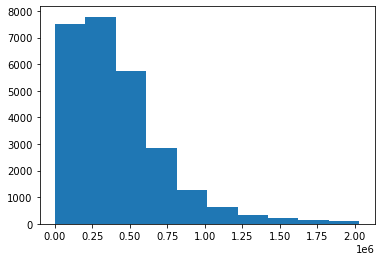

In [72]:
plt.hist(y_train)

In [73]:
# Perform Feature Selection using Recursive Feature Elimination
# Initialize ML algorithm
lm = LinearRegression()
# create RFE object - selects top 3 features only
rfe = RFE(lm, n_features_to_select=3)
# fit the data using RFE
rfe.fit(X_train_scaled, y_train)
# get mask of columns selected
feature_mask = rfe.support_
# get list of column names
rfe_features = X_train_scaled.iloc[:,feature_mask].columns.tolist()
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')


,Var,Rank
7,bedroom_scaled,1
8,bathroom_scaled,1
14,room_count_scaled,1
9,square_feet_scaled,2
13,living_space_scaled,3
15,bed_to_bath_scaled,4
6,is_LA,5
10,condition_scaled,6
12,age_scaled,7
0,pool,8


In [74]:
X_train_scaled = X_train_scaled[rfe_features]
X_validate_scaled = X_validate_scaled[rfe_features]
X_test_scaled = X_test_scaled[rfe_features]

In [75]:
X_train_scaled.head()

,bedroom_scaled,bathroom_scaled,room_count_scaled
51939,-1.0,-1.0,-1.333333
36613,1.0,-1.0,0.000000
5227,0.0,0.0,0.000000
19889,-1.0,0.0,-0.666667
22308,-1.0,-1.0,-1.333333


In [76]:
predictions = pd.DataFrame({
    'actual': validate.tax_value
})

## Baseline

In [77]:
# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  323299.09 
Validate/Out-of-Sample:  321869.8
RMSE using Median
Train/In-Sample:  329639.21 
Validate/Out-of-Sample:  327697.62


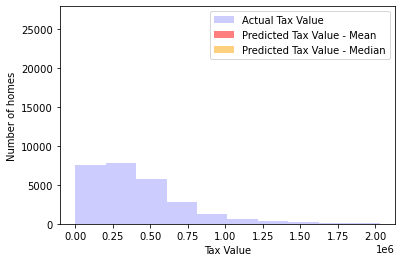

In [78]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.2, label="Actual Tax Value")
plt.hist(y_train.tax_value_pred_mean, bins=1, color='red', alpha=.5, rwidth=1171100, label="Predicted Tax Value - Mean")
plt.hist(y_train.tax_value_pred_median, bins=1, color='orange', alpha=.5, rwidth=1171100, label="Predicted Tax Value - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of homes")
plt.legend()
plt.show()


In [79]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  295814.51852181513 
Validation/Out-of-Sample:  296720.8224777529


In [80]:
# create the model object
lars = LassoLars(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using LarsLasso\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)



RMSE for OLS using LarsLasso
Training/In-Sample:  295803.9333239102 
Validation/Out-of-Sample:  296657.01045325707


In [81]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  293467.6626010589 
Validation/Out-of-Sample:  294942.7751872143


### Polynomial Features

In [82]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2,interaction_only=False)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)


In [83]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  292965.9140967792 
Validation/Out-of-Sample:  294720.2137733318


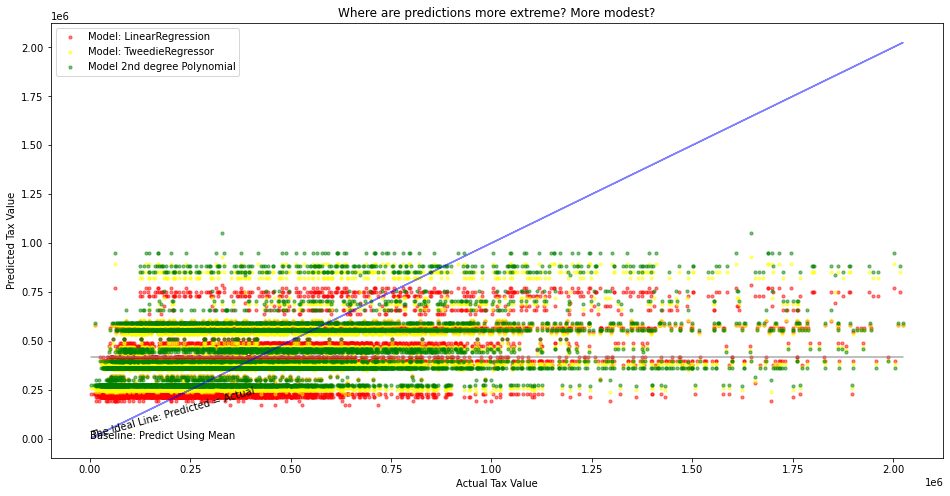

In [84]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=10, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=10, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=10, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


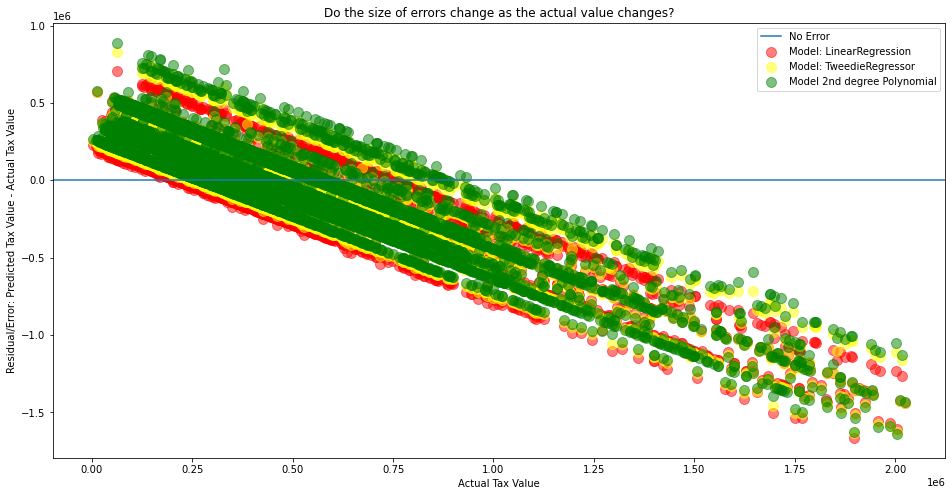

In [85]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

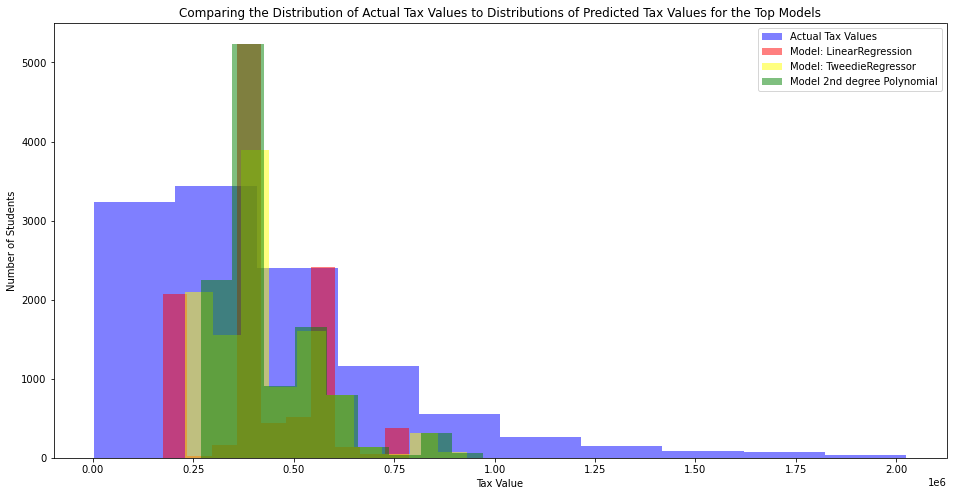

In [86]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()


In [87]:
y_validate

,tax_value,tax_value_pred_mean,tax_value_pred_median,tax_value_pred_lm,tax_value_pred_lars,tax_value_pred_glm,tax_value_pred_lm2
27531,205368.0,417896.0586,353555.5,397024.0586,397717.532627,380165.248979,361800.0586
4309,461000.0,417896.0586,353555.5,173712.0586,170394.495197,227942.664481,362632.0586
26884,104713.0,417896.0586,353555.5,397024.0586,397717.532627,380165.248979,361800.0586
6687,116753.0,417896.0586,353555.5,378352.0586,376586.100493,364294.883300,359899.0586
1924,700000.0,417896.0586,353555.5,471328.0586,469116.187074,450824.100521,440680.0586
...,...,...,...,...,...,...,...
25830,735931.0,417896.0586,353555.5,397024.0586,397717.532627,380165.248979,361800.0586
16158,436995.0,417896.0586,353555.5,397024.0586,397717.532627,380165.248979,361800.0586
7155,617840.0,417896.0586,353555.5,229728.0586,233788.791599,259050.033264,271848.0586
16882,165374.0,417896.0586,353555.5,582992.0586,582777.705789,582211.155165,589128.0586


In [88]:
pd.concat([
    y_validate.apply(lambda col: r2_score(y_validate.tax_value, col)).rename('r2'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.tax_value, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(lambda x: x**0.5)
)

,r2,mse,rmse
tax_value,1.000000,0.000000e+00,0.000000
tax_value_pred_mean,-0.000073,1.036002e+11,321869.800823
tax_value_pred_median,-0.036616,1.073857e+11,327697.621686
tax_value_pred_lm,0.150101,8.804325e+10,296720.822478
tax_value_pred_lars,0.150466,8.800538e+10,296657.010453
tax_value_pred_glm,0.160256,8.699124e+10,294942.775187
tax_value_pred_lm2,0.161523,8.686000e+10,294720.213773


# Predict on Test

In [89]:
# y_test = pd.DataFrame(y_test)

# # predict on test
# y_test['tax_value_pred_lm'] = lm.predict(X_test)

# # evaluate: rmse
# rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm)**(1/2)

# print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)
